In [8]:
import os
import json
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

from postamats.utils import prepare_data, helpers
from postamats.utils.connections import DB
from postamats.global_constants import APARTMENT_HOUSES_NAME, ALL_METRO_NAME, ALL_OBJECTS_NAME
from postamats.utils.connections import PATH_TO_ROOT

pd.set_option('display.max_columns', None)

In [200]:
# сколько всего постаматов в планах
TOTAL_POSTAMATS = 10**4
# какой радиус по умолчанию обслуживает 1 установленный постамат
MAX_ACTIVE_RADIUS = 400
MAX_POSTAMAT_AREA = np.pi * MAX_ACTIVE_RADIUS ** 2

In [271]:
def plot_map(
    cartes1: pd.DataFrame,
    cartes2=None,
    size1=10,
    size2=1,
    alpha1=.2,
    alpha2=1,
    c1='b',
    c2='r'):

    mos_img = plt.imread(os.path.join(PATH_TO_ROOT, 'data', 'images', 'map.png'))

    bbox_geo = (37.3260, 37.9193, 55.5698, 55.9119)
    bbox_cartes = helpers.calc_cartesian_coords(bbox_geo[2:], bbox_geo[:2])
    bbox = bbox_cartes['x'].to_list() + bbox_cartes['y'].to_list()

    fig, ax = plt.subplots(figsize=(12,12))
    ax.scatter(cartes1['x'], cartes1['y'], zorder=1, alpha=alpha1, c=c1, s=size1)
    if cartes2 is not None:
        ax.scatter(cartes2['x'], cartes2['y'], zorder=1, alpha=alpha2, c=c2, s=size2)

    ax.set_xlim(bbox[0],bbox[1])
    ax.set_ylim(bbox[2],bbox[3])
    ax.axis('off')
    ax.imshow(mos_img, zorder=0, extent=bbox, aspect='equal')
    plt.show()

In [11]:
def my_f1_score(mean_walk_time: float,
                mean_population: float,
                mean_wt_min: float,
                mean_population_max: float) -> float:
    """Скор для каждой выбранной тчки установки постамата

    Args:
        mean_walk_time (float): среднее время в пути для данной точки
        sum_population (float): суммарное кол-во людей, которое обслуживает точка
        mean_wt_min (float): минимальное среднее время в пути по всем выставленным точкам
        sum_population_max (float): максимальное суммарное кол-во людей, которое обслуживает точка
        по всем точкам

    Returns:
        float: геометрическое среднее, аналог f1-меры
    """
    wt_score = mean_wt_min/mean_walk_time
    pop_score = mean_population / mean_population_max
    return 2 * (wt_score) * (pop_score) / (wt_score + pop_score)

In [12]:
CONFIG_PATH = os.path.join(PATH_TO_ROOT, 'db_config.json')
with open(CONFIG_PATH, mode='r') as db_file:
    db_config = json.load(db_file)
database = DB(db_config)

Загружаем базы

In [13]:
apart_query = "select object_id, lat, lon, object_type, population from public.apartment_houses_all_data"
metro_query = "select object_id_metro, lat, lon, object_type from public.all_metro_objects_data where object_type='кластер входов в метро'"
points_query = 'select object_id, lat, lon, object_type from public.all_objects_data'

In [14]:
all_apart = database.get_by_sql(apart_query)
all_metro = database.get_by_sql(metro_query)
all_points = database.get_by_sql(points_query)

Connection to PostgreSQL DB successful


/Users/affernus/PROJECTS/hacks/postomat_optimisation/src/postamats/utils/connections.py:114: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Connection to PostgreSQL DB successful
Connection to PostgreSQL DB successful


/Users/affernus/PROJECTS/hacks/postomat_optimisation/src/postamats/utils/connections.py:114: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)
/Users/affernus/PROJECTS/hacks/postomat_optimisation/src/postamats/utils/connections.py:114: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Эмулируем входящий json

In [15]:
# пусть мы собираемся поставить 500 постаматов
# мы выбрали 15000 точек для их расстановки
# и ещё 500 точек забанили
not_aparts_points = all_points[all_points['object_type']!='многоквартирный дом']
json_input = {
    'postamat_quant': 500,
    'possible_points': not_aparts_points['object_id'].to_list(),#all_points.sample(n=15000, random_state=0)['object_id'].to_list(),
    'fixed_points': not_aparts_points.sample(n=100, random_state=0)['object_id'].to_list(),
    'metro_priority': 0.5,
    'large_houses_priority': 0.5,
    'adm_area': [],
    'district': []
}

with open('json_input.json', 'w') as fp:
    json.dump(json_input, fp, indent=4)

In [16]:
with open('json_input.json', mode='r') as f:
    json_input = json.load(f)

possible_points = json_input['possible_points']
fixed_points = json_input['fixed_points']
postamat_quant = json_input['postamat_quant']

In [17]:
# Зафиксированные точки мы исключаем из расчета
# и исключаем дома вокруг них из оптимизации, т.к. считаем, что они уже обслуживаются установленной точкой
# для этого из таблицы APARTMENT_HOUSES_NAME исключаем жилые дома, расстояние от которых до точек,
# где уже стоит постамат, меньше порога

# расчет мы в любом случае делаем для TOTAL_POSTAMATS - fixed_points,
# но затем от всех полученных рекомендованных точек установки берем топ n_points_to_place по метрике

In [18]:
# считаем картезиановы координаты
all_apart_cartes = helpers.calc_cartesian_coords(all_apart['lat'], all_apart['lon'])
all_apart_cartes.index = all_apart.index
all_apart = all_apart.join(all_apart_cartes)

In [19]:
all_points_cartes = helpers.calc_cartesian_coords(all_points['lat'], all_points['lon'])
all_points_cartes.index = all_points.index
all_points = all_points.join(all_points_cartes)

In [20]:
fixed_points_df = all_points.loc[all_points['object_id'].isin(fixed_points), :].copy()

In [21]:
def remove_or_select_nearest(remove_or_select_from: pd.DataFrame,
                            whose_neighbors_remove_or_select: pd.DataFrame,
                            distance_threshold: float=MAX_ACTIVE_RADIUS,
                            action: str='remove'):
    """Убирает или оставляет в remove_or_select_from точки вокруг точек из whose_neighbors_remove
    Args:
        remove_or_select_from (pd.DataFrame): откуда удалять/выбирать объекты
        whose_neighbors_remove_or_select (pd.DataFrame): объекты, окружающие какие точки удалять
        distance_threshold (float, optional): в каком радиусе вокруг whose_neighbors_remove
         удалять точки из remove_from. Defaults to POSTAMAT_TERRITORY_RADIUS.
        action (str): 'remove' - удалять точки, 'select' - добавлять точки
    """
    if action not in ['remove', 'select']:
        raise ValueError(f"action must be 'remove' or 'select', {action} received")

    dist = pairwise_distances(remove_or_select_from[['x', 'y']], whose_neighbors_remove_or_select[['x', 'y']])
    to_remove_or_select = set( np.where(dist < distance_threshold)[0] )
    cond = remove_or_select_from.index.isin(to_remove_or_select)
    if action=='remove':
        cond = ~cond
    return remove_or_select_from[cond]

In [22]:
# фильтруем данные о зификсированных точках
# удаляем из расчета те дома, которые уже обслуживаются постаматом
cleaned_apart = remove_or_select_nearest(all_apart, fixed_points_df)

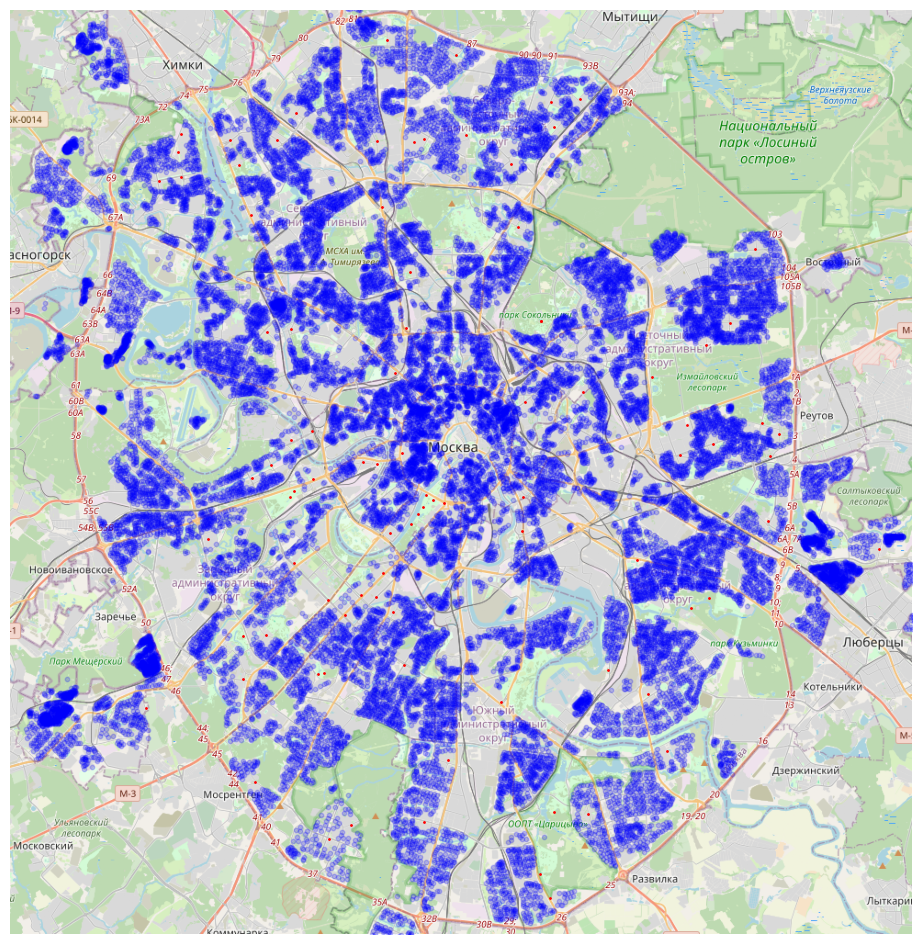

In [23]:
plot_map(cleaned_apart, fixed_points_df)

In [24]:
# # теперь нам нужно исключить зафиксированные точки из возможных точек расстановки
cleaned_points = all_points[~all_points['object_id'].isin(fixed_points)]
# также надо взять только точки, доступные для установки
cleaned_points = cleaned_points[cleaned_points['object_id'].isin(possible_points)]

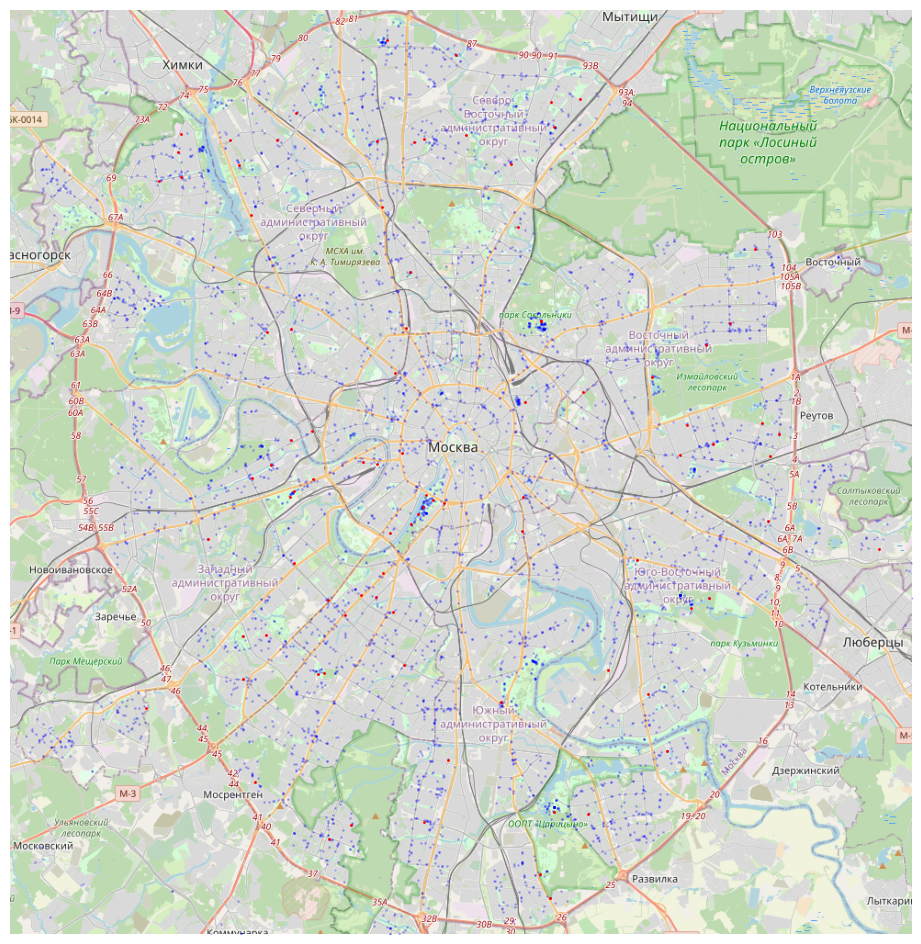

In [25]:
plot_map(cleaned_points, fixed_points_df, size1=1, size2=1, alpha1=1, alpha2=1)

In [113]:
# Постаматы имеют эффективный радиус действия, оставляем только те дома,
# которые находятся в границах эффективного радиуса действия постаматов
# радиус берем с запасом 400 * 3 = 1200 м
cleaned_apart = remove_or_select_nearest(all_apart,
                                        cleaned_points,
                                        distance_threshold=3*MAX_ACTIVE_RADIUS,
                                        action='select')

In [151]:
cleaned_apart
cleaned_points

object_id        lat  \
19     b819ec2781bebd714e39a3e9d0133709397868b238d6e7...  55.743530   
36     96972d29fc38c1d110f3fb99094405316bca1b50f14975...  55.685502   
52     86f5a1e05ec185197c14503faf891949e53f6acd2e082a...  55.626568   
84     e004c2cb0b81e7b2f66bdeee7a429455952cb85c08a15e...  55.788708   
100    17b7340ac1f8eec8f3faca28e65b92abf025abab0ea2ec...  55.893192   
...                                                  ...        ...   
43182  0bd2902029c3d36f6ead25fe181b92b25bd816cdad8a5b...  55.974472   
43183  c350a792c7f85c3a19cceccabbee229e762627670c3d2f...  55.962885   
43184  703ecf2861165481f798ca73c3b17a3f3d5eabbdbc7b94...  55.614951   
43185  9a4d692b68af938eeb2710c530c946516dcb39d85a9e62...  55.734761   
43186  e3954a1c7efddf7f1bf68aaa6afe085044ac28bee7f103...  55.708107   

             lon        object_type             x             y  
19     37.820679              киоск  12686.012146  -1369.840337  
36     37.922644  cпортивный объект  19058.680895  -7814.811323  
52     37.594760  cпортивный объект  -1433.603825 -14360.337356  
84     37.730733  cпортивный объект   7064.532804   3647.872675  
100    37.622043  cпортивный объект    271.541097  15252.336394  
...          ...                ...           ...           ...  
43182  37.155215  cпортивный объект -28904.536147  24279.753681  
43183  37.174221  cпортивный объект -27716.682477  22992.855239  
43184  37.713617  cпортивный объект   5994.805655 -15650.509419  
43185  37.456232  cпортивный объект -10091.423495  -2343.853571  
43186  37.735709  cпортивный объект   7375.524688  -5304.175387  

[5060 rows x 6 columns]

In [189]:
apart_vs_points = pd.concat([cleaned_apart, cleaned_points], ignore_index=True)
apart_vs_points['is_point'] = apart_vs_points['object_id'].isin(cleaned_points['object_id'])
sample_weight = pd.Series(index=apart_vs_points.index, data=1)
sample_weight[apart_vs_points['is_point']] = 0

In [190]:
# теперь мы кластеризуем оставшиес точки притяжения
dbscan = DBSCAN(eps=400, min_samples=5)
labels=dbscan.fit_predict(apart_vs_points[['x', 'y']], sample_weight=sample_weight)
print(len(set(labels)))
apart_vs_points['label'] = labels

54


In [197]:
apart_wo_points = apart_vs_points[~apart_vs_points['is_point']].copy()

set_labels = set(labels)
len_labels = len(set_labels)

pop_density = np.zeros((len_labels,))
total_area = np.zeros((len_labels,))

for lbl in set(apart_wo_points['label']).difference({-1}):

    slice = apart_wo_points[apart_wo_points['label']==lbl].copy()

    x_step, y_step = 100, 100
    cell_area = x_step * y_step

    slice['x_step'] = (slice['x'] // x_step).astype(int)
    slice['y_step'] = (slice['y'] // y_step).astype(int)
    population_by_cell = slice.groupby(['x_step', 'y_step'])['population'].sum()
    total_area[lbl] = population_by_cell.shape[0] * cell_area
    population_density = population_by_cell.sum() / total_area[lbl]
    pop_density[lbl] = population_density

top_densities = np.argsort(pop_density)[::-1]

In [309]:
def set_cluster_postamats(clust_df, clust_area, remain_postamats_quant, dist_thresh=2*MAX_ACTIVE_RADIUS):
    points = clust_df[clust_df['is_point']].copy()
    result = []
    if points.shape[0]==0:
        return result

    n_clusters = 2* int(np.ceil(clust_area / MAX_POSTAMAT_AREA)))
    # TODO: ставить больше кластеров и выбирать топ лучших
    # проверять, что кластеры стоят слишком близко

    clusterer = KMeans(n_clusters=n_clusters)
    clusterer.fit_predict(clust_df.loc[~clust_df['is_point'], ['x', 'y']])
    centers = pd.DataFrame(data=clusterer.cluster_centers_, columns=['x', 'y'])

    dist = pairwise_distances(centers[['x', 'y']], points[['x', 'y']])

    neares_to_centers = set(dist.argmin(axis=1))

    closer_then_thresh = set(np.where(dist < dist_thresh)[1])

    to_select = list( set(neares_to_centers) & set(closer_then_thresh) )

    if not to_select:
        return result

    return points.loc[points.index[to_select], 'object_id'].to_list()
    

In [319]:
point_ids = []
remain_postamats_quant = 1000
for lbl in top_densities:
    new_ids = []
    if remain_postamats_quant <= 0:
        break
    lbl_cond = apart_vs_points['label']==lbl
    new_ids = set_cluster_postamats(apart_vs_points[lbl_cond], total_area[lbl], remain_postamats_quant)
    point_ids += new_ids
    remain_postamats_quant -= len(new_ids)

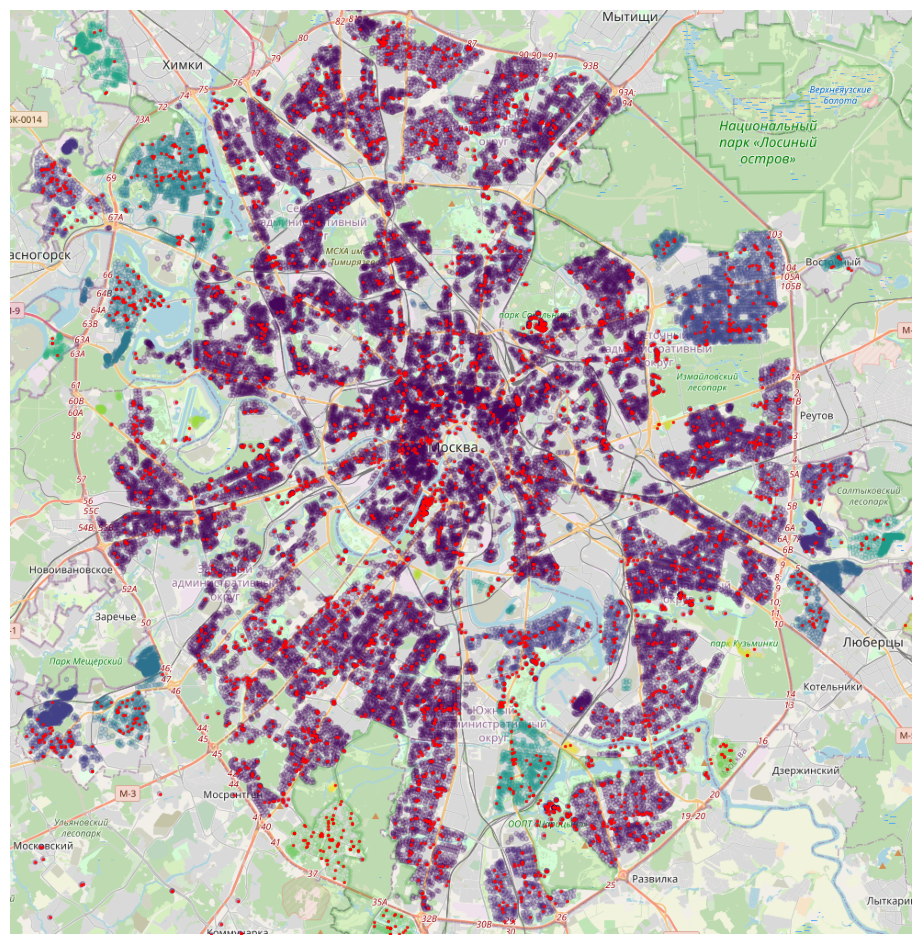

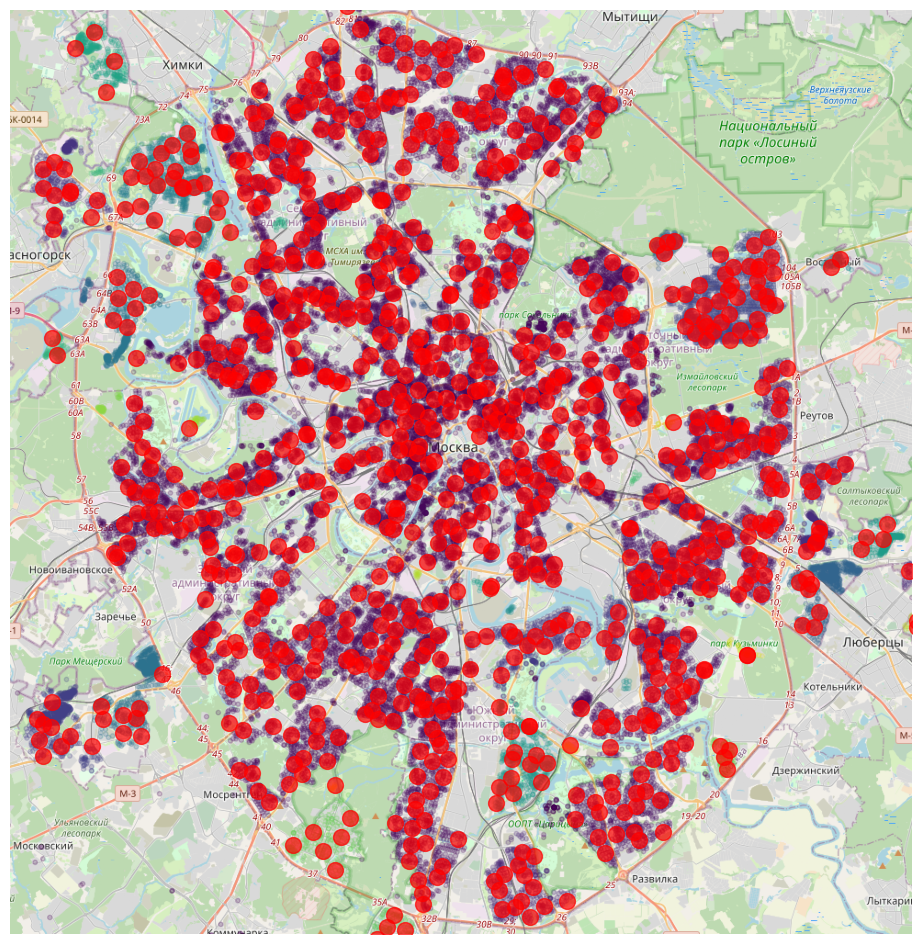

In [320]:
plot_map(apart_vs_points, cleaned_points, c1=labels, c2='r', size2=2, alpha2=.7)
plot_map(apart_vs_points, all_points[all_points['object_id'].isin(point_ids)], c1=labels, c2='r', size2=130, alpha2=.7)